In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phys591000-dijet-generative-model/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5
/kaggle/input/phys591000-dijet-generative-model/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5
/kaggle/input/phys591000-dijet-generative-model/events_anomalydetection_DelphesHerwig_qcd_features.h5


# Data structure

In [2]:
h_QCD_data = pd.read_hdf('../input/phys591000-dijet-generative-model/events_anomalydetection_DelphesHerwig_qcd_features.h5')
W_data = pd.read_hdf('../input/phys591000-dijet-generative-model/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5')
p_QCD_data = pd.read_hdf('../input/phys591000-dijet-generative-model/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5')


In [3]:
print(h_QCD_data.shape, h_QCD_data.columns)
print(W_data.shape, W_data.columns)
print(p_QCD_data.shape, p_QCD_data.columns)

(999999, 14) Index(['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
       'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2'],
      dtype='object')
(99999, 14) Index(['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
       'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2'],
      dtype='object')
(999999, 14) Index(['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
       'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2'],
      dtype='object')


### Main feature calculation

This cell is to compute the total mass and the ratio of tau2 and tau1 ($\tau_2 / \tau_1$) of leading jets and subleading jets.

In [4]:
def append_total_mass(data):
    E1=np.sqrt(((data['pzj1']**2)+(data['pyj1']**2)+(data['pxj1']**2)+(data['mj2'])**2))
    E2=np.sqrt(((data['pzj2']**2)+(data['pyj2']**2)+(data['pxj2']**2)+(data['mj1'])**2))
    E=E1+E2
    px=(data['pxj2'])+(data['pxj1'])
    py=(data['pyj2'])+(data['pyj1'])
    pz=(data['pzj2'])+(data['pzj1'])
    p=np.sqrt((px)**2+(py)**2+(pz)**2)
    #mjj=np.sqrt(Ejj**2-((px)**2+(py)**2+(pz)**2))
    total_mass = np.sqrt((E**2)-(p**2))
    data['mjj'] = total_mass
    return data
    
h_QCD_data = append_total_mass(h_QCD_data)
W_data = append_total_mass(W_data)
p_QCD_data = append_total_mass(p_QCD_data)

h_QCD_data['tau21j1'] = h_QCD_data['tau2j1'] / h_QCD_data['tau1j1']
h_QCD_data['tau21j2'] = h_QCD_data['tau2j2'] / h_QCD_data['tau1j2']
W_data['tau21j1'] = W_data['tau2j1'] / W_data['tau1j1']
W_data['tau21j2'] = W_data['tau2j2'] / W_data['tau1j2']
p_QCD_data['tau21j1'] = p_QCD_data['tau2j1'] / p_QCD_data['tau1j1']
p_QCD_data['tau21j2'] = p_QCD_data['tau2j2'] / p_QCD_data['tau1j2']

# Data visulization

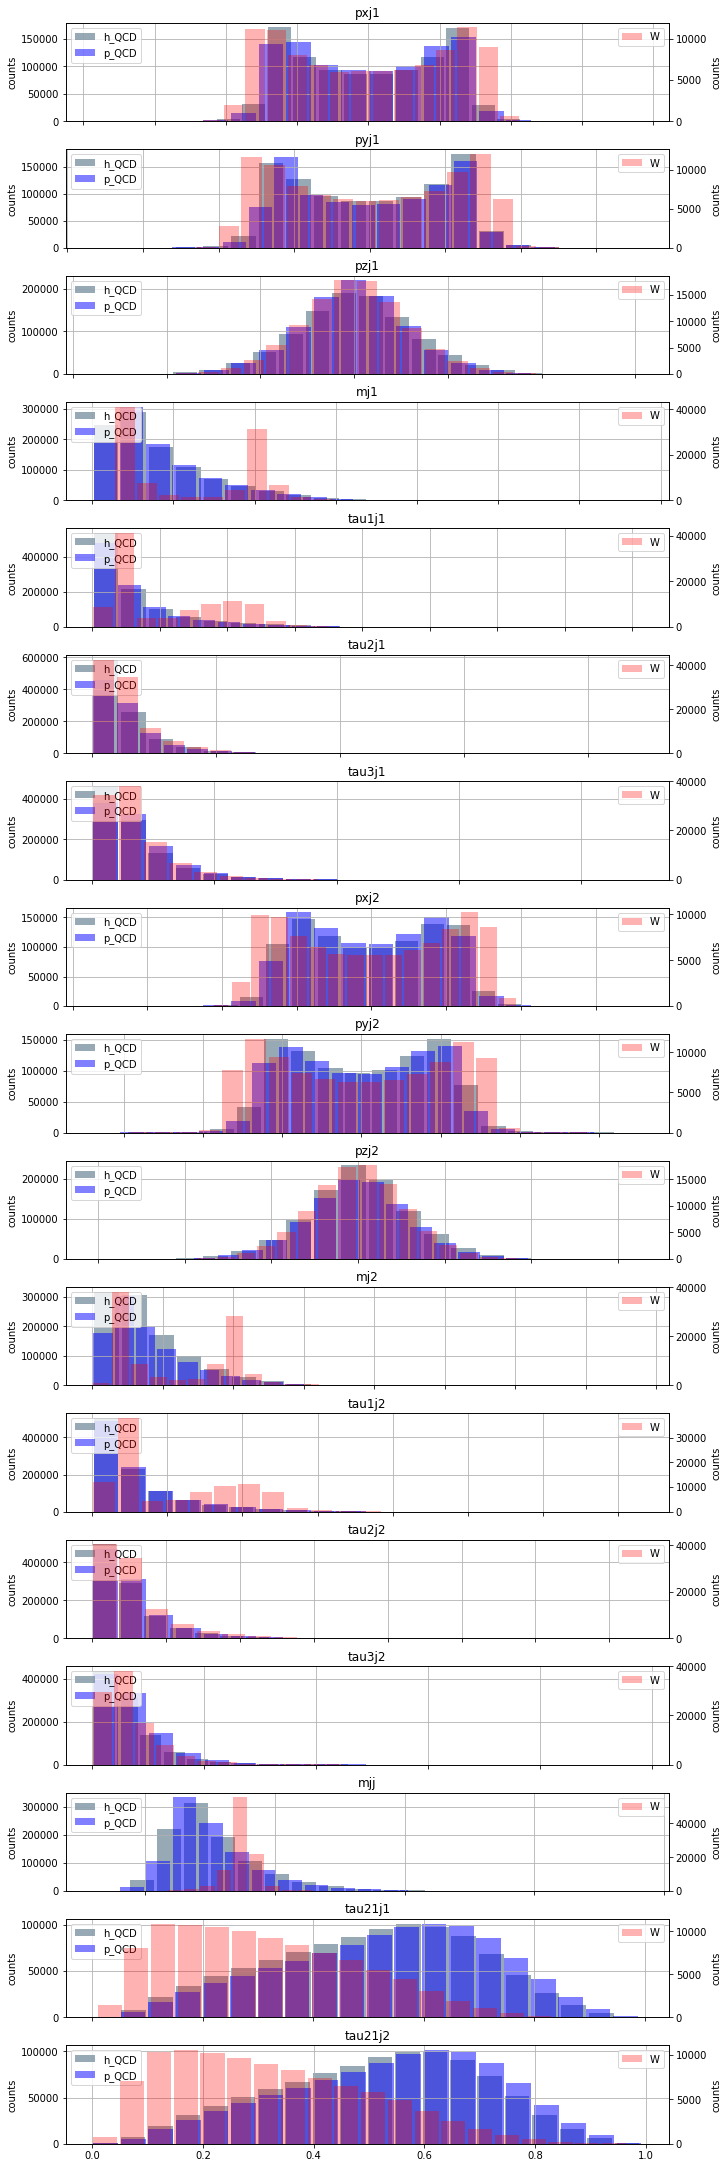

In [5]:
import matplotlib.pyplot as plt
flag = 0
fig, axes = plt.subplots(nrows=len(h_QCD_data.columns), ncols = 1, figsize=(10, 30), constrained_layout=True)

for feature in h_QCD_data.columns:
    ax2 = axes[flag].twinx()
    h_QCD_data[feature].plot.hist(grid=True, bins=20, rwidth=0.9,color='#607c8e', ax=axes[flag], alpha = 0.65, label = 'h_QCD')
    W_data[feature].plot.hist(grid=True, bins=20, rwidth=0.9,color='red', ax=ax2, alpha = 0.3, label = 'W')
    p_QCD_data[feature].plot.hist(grid=True, bins=20, rwidth=0.9,color='blue', ax=axes[flag], alpha = 0.5, label = 'p_QCD')
    axes[flag].legend(loc=2)
    ax2.legend(loc=0)
    plt.title(feature)
    plt.xlabel('Counts')
    axes[flag].set_ylabel('counts')
    ax2.set_ylabel('counts')
    plt.grid(axis='y', alpha=0.75)
    flag += 1

### Main feature

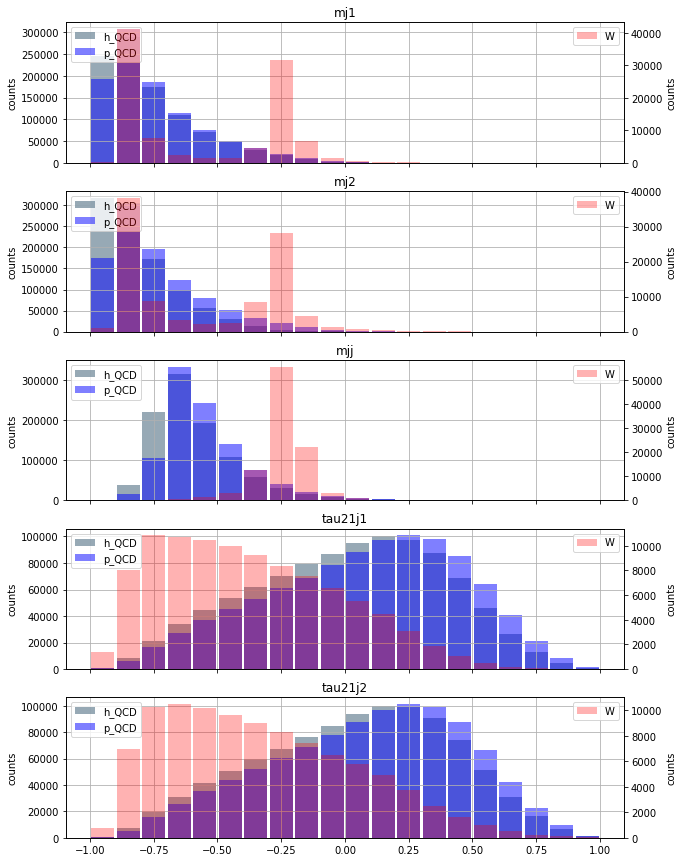

In [6]:
"""
Define Features
"""
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
h_QCD_data = append_total_mass(h_QCD_data)
W_data = append_total_mass(W_data)
p_QCD_data = append_total_mass(p_QCD_data)

training_features_h_QCD_data = h_QCD_data[['mj1','mj2', 'mjj', 'tau21j1', 'tau21j2']]
training_features_W_data = W_data[['mj1','mj2', 'mjj', 'tau21j1', 'tau21j2']]
training_features_p_QCD_data = p_QCD_data[['mj1','mj2', 'mjj', 'tau21j1', 'tau21j2']]

"""
Normalize all inputs between -1 and 1
"""
scaler = MinMaxScaler(feature_range = (-1, 1))
training_features_h_QCD_data[['mj1','mj2', 'mjj', 'tau21j1', 'tau21j2']] = \
                    scaler.fit_transform(training_features_h_QCD_data[['mj1','mj2', 'mjj', 'tau21j1', 'tau21j2']])
training_features_W_data[['mj1','mj2', 'mjj', 'tau21j1', 'tau21j2']] = \
                    scaler.fit_transform(training_features_W_data[['mj1','mj2', 'mjj', 'tau21j1', 'tau21j2']])
training_features_p_QCD_data[['mj1','mj2', 'mjj', 'tau21j1', 'tau21j2']] = \
                    scaler.fit_transform(training_features_p_QCD_data[['mj1','mj2', 'mjj', 'tau21j1', 'tau21j2']])
    
flag = 0
fig, axes = plt.subplots(nrows=len(training_features_h_QCD_data.columns), ncols = 1, figsize=(10, 15))
for feature in training_features_h_QCD_data.columns:
    ax2 = axes[flag].twinx()
    training_features_h_QCD_data[feature].plot.hist(grid=True, bins=20, rwidth=0.9,color='#607c8e', ax=axes[flag], alpha = 0.65, label = 'h_QCD')
    training_features_W_data[feature].plot.hist(grid=True, bins=20, rwidth=0.9,color='red', ax=ax2, alpha = 0.3, label = 'W')
    training_features_p_QCD_data[feature].plot.hist(grid=True, bins=20, rwidth=0.9,color='blue', ax=axes[flag], alpha = 0.5, label = 'p_QCD')
    axes[flag].legend(loc=2)
    ax2.legend(loc=0)
    plt.title(feature)
    plt.xlabel('Counts')
    axes[flag].set_ylabel('counts')
    ax2.set_ylabel('counts')
    plt.grid(axis='y', alpha=0.75)
    flag += 1

# Discussion

Ans: The mission here is to distinguish the BSM event from the QCD background, and  train the generative model GAN or VAE to generate new data. From $m_{j1}$ and $m_{j2}$, we can see that there are two obvious peak for W dataset that indicate X and Y which mass are 500 Gev and 100 GeV. Furthermore, from low-level data, we can get the total mass by the four-momentums and also a distinguishable $\tau_{21}$ from the ratio of $\tau_{2}$, $\tau_{1}$. In future works, we can use those 5 feature to train our generative model.